# Song popularity dataset
Predicting the popularity of a song

### Importing library's

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## EDA

In [78]:
df = pd.read_csv("archive/song_data.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [79]:
df.shape

(18835, 15)

In [80]:
df.drop_duplicates(subset='song_name', keep='first', inplace=True)
df.shape

(13070, 15)

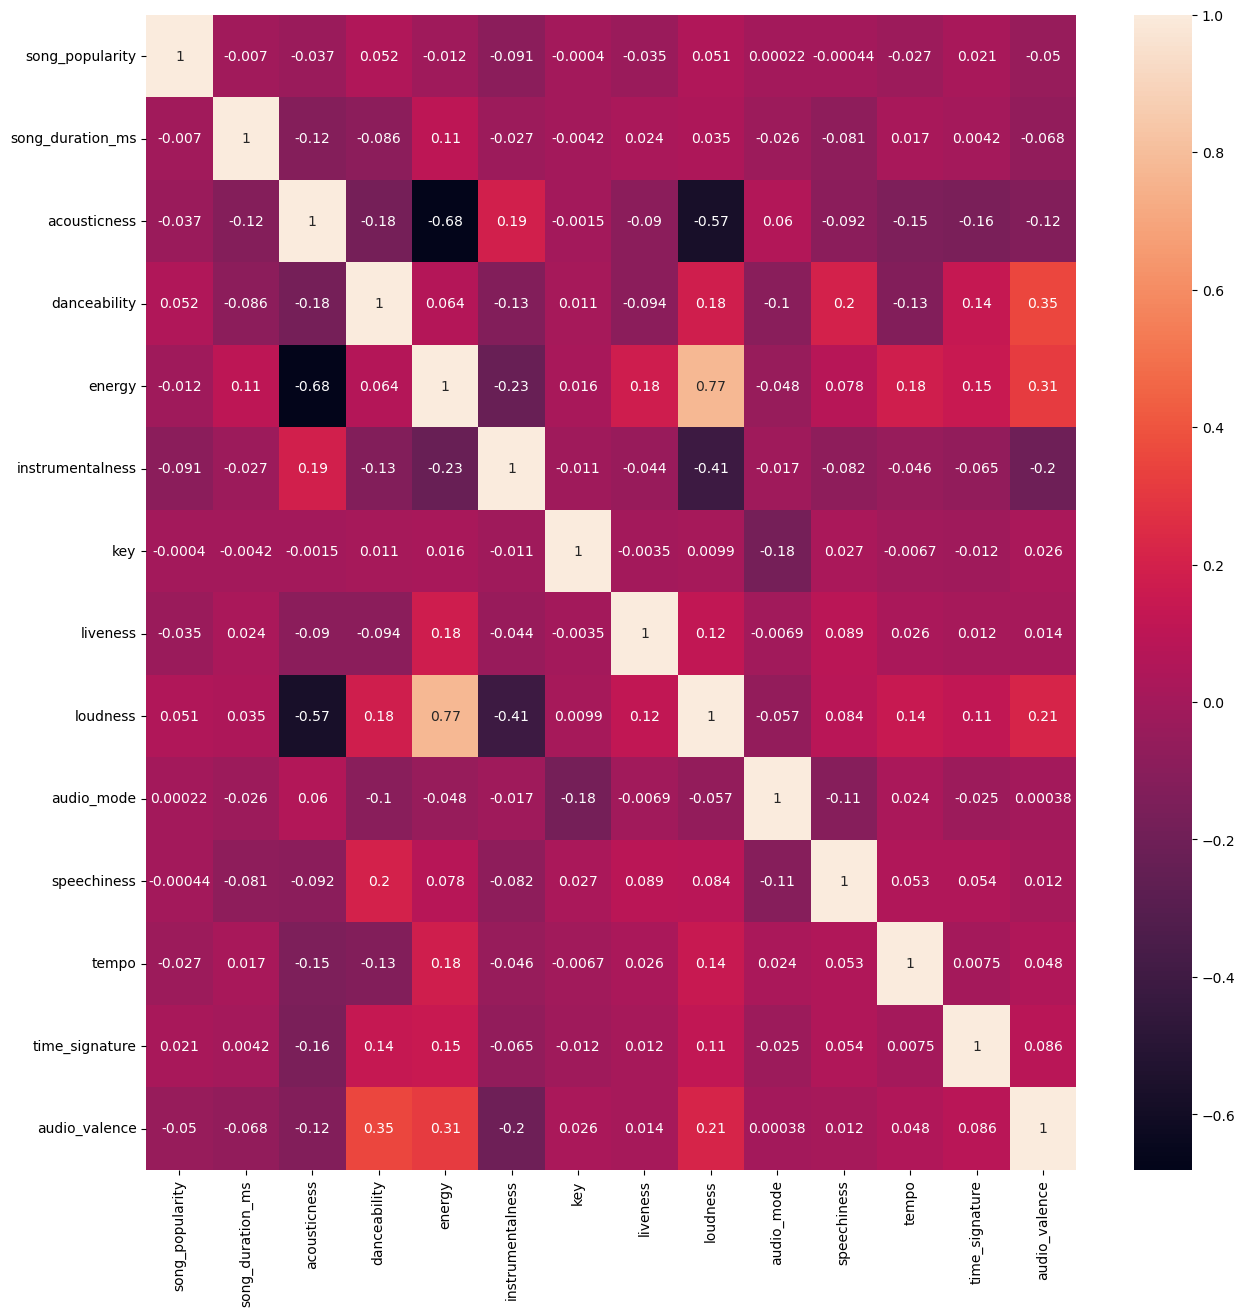

In [81]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot= True,)
plt.show()

In [82]:
df = df.drop(['song_name','loudness'], axis=1);
df.shape

(13070, 13)

In [83]:
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,1,0.0313,172.011,4,0.574


One hot encoding not needed cause all of the features are already numbers

## Making the model

In [84]:
RANDOM_STATE = 42
features = [x for x in df.columns if x not in 'song_popularity']

In [85]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['song_popularity'], train_size = 0.8, random_state = RANDOM_STATE)

In [89]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Look at min_samples_split_list

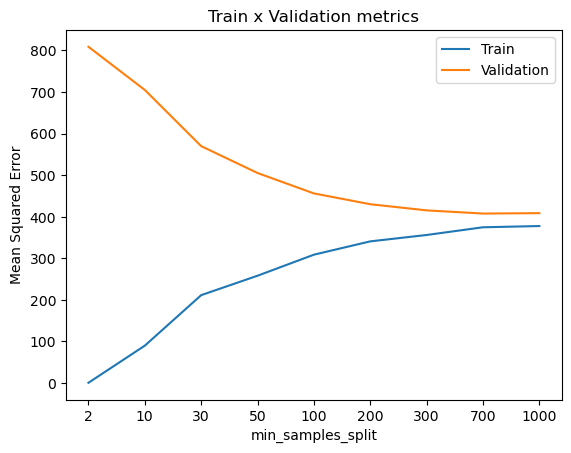

In [90]:
mse_list_train = []
mse_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train, y_train)
    mse_val = mean_squared_error(predictions_val, y_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

### Look at max_depth_list

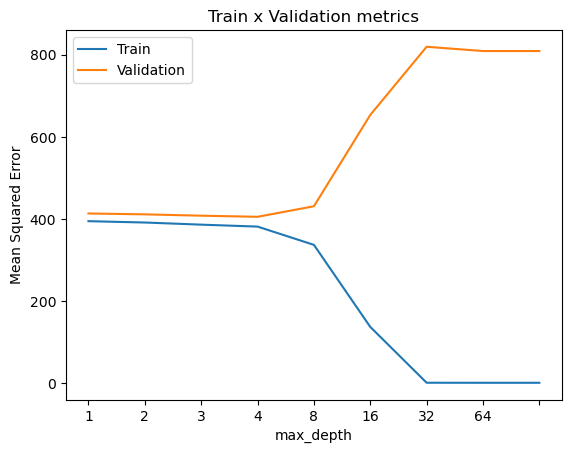

In [88]:
mse_list_train = []
mse_list_val = []

for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train, y_train)
    mse_val = mean_squared_error(predictions_val, y_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])



## Choose best hyperparameters for decision tree model

In [91]:
best_min_samples_split = 1000
best_max_depth = 4

In [93]:
decision_tree_model = DecisionTreeRegressor(min_samples_split = best_min_samples_split,
                                             max_depth = best_max_depth,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [95]:
# Predictions for the train and validation sets
predictions_train = decision_tree_model.predict(X_train)
predictions_val = decision_tree_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(predictions_train, y_train)
mse_val = mean_squared_error(predictions_val, y_val)

# Print the metrics
print(f"Metrics train:\n\tMean Squared Error: {mse_train:.4f}")
print(f"Metrics validation:\n\tMean Squared Error: {mse_val:.4f}")

Metrics train:
	Mean Squared Error: 382.7538
Metrics validation:
	Mean Squared Error: 405.0323
